# Labeled Faces In The Wild Deep Learning Classification


## Desription

The LFW (Labeled Faces In The Wild) dataset is composed of 5479 clases (different persons) for more than 13000 images.

## Initialization

In [83]:
# IMSIZE = [250, 250, 3]
DATASET_PATH = "../datasets/lfw_funneled"

## Load and split dataset

In [84]:
import tensorflow as tf

batch_size = 32
SEED = 123
w, h, l = 94, 125, 3
IMG_SHAPE = (h, w, l)

train_ds = tf.keras.utils.image_dataset_from_directory(DATASET_PATH,
                                                       validation_split=0.2,
                                                       subset="training",
                                                       seed=SEED,
                                                       image_size=(h, w),
                                                       batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(DATASET_PATH,
                                                     validation_split=0.2,
                                                     subset="validation",
                                                     seed=SEED,
                                                     image_size=(h, w),
                                                     batch_size=batch_size)

class_names = train_ds.class_names
n_classes = len(class_names)

Found 1240 files belonging to 62 classes.
Using 992 files for training.
Found 1240 files belonging to 62 classes.
Using 248 files for validation.


## Show images infos

In [85]:
print(class_names)
print(f"Image dimensions: {w}x{h}x{l}")
print(f"Number of classes: {n_classes}")

['Alejandro_Toledo', 'Alvaro_Uribe', 'Amelie_Mauresmo', 'Andre_Agassi', 'Angelina_Jolie', 'Ariel_Sharon', 'Arnold_Schwarzenegger', 'Atal_Bihari_Vajpayee', 'Bill_Clinton', 'Carlos_Menem', 'Colin_Powell', 'David_Beckham', 'Donald_Rumsfeld', 'George_Robertson', 'George_W_Bush', 'Gerhard_Schroeder', 'Gloria_Macapagal_Arroyo', 'Gray_Davis', 'Guillermo_Coria', 'Hamid_Karzai', 'Hans_Blix', 'Hugo_Chavez', 'Igor_Ivanov', 'Jack_Straw', 'Jacques_Chirac', 'Jean_Chretien', 'Jennifer_Aniston', 'Jennifer_Capriati', 'Jennifer_Lopez', 'Jeremy_Greenstock', 'Jiang_Zemin', 'John_Ashcroft', 'John_Negroponte', 'Jose_Maria_Aznar', 'Juan_Carlos_Ferrero', 'Junichiro_Koizumi', 'Kofi_Annan', 'Laura_Bush', 'Lindsay_Davenport', 'Lleyton_Hewitt', 'Luiz_Inacio_Lula_da_Silva', 'Mahmoud_Abbas', 'Megawati_Sukarnoputri', 'Michael_Bloomberg', 'Naomi_Watts', 'Nestor_Kirchner', 'Paul_Bremer', 'Pete_Sampras', 'Recep_Tayyip_Erdogan', 'Ricardo_Lagos', 'Roh_Moo-hyun', 'Rudolph_Giuliani', 'Saddam_Hussein', 'Serena_Williams', 'S

## Show images

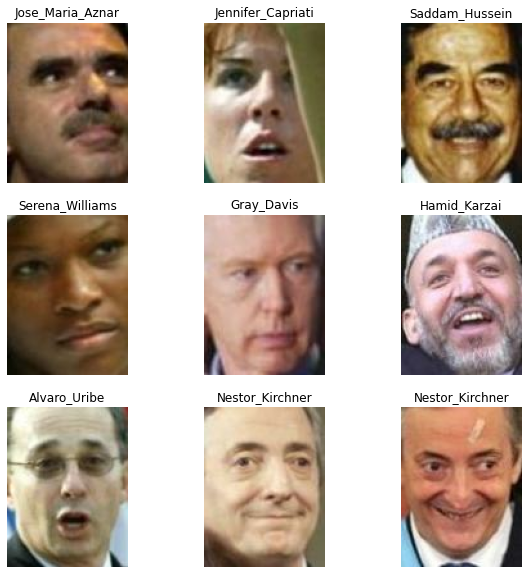

In [86]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [87]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(train_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(val_ds))

Number of validation batches: 31
Number of test batches: 8


## Configure dataset performance

In [88]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_dataset = val_ds.prefetch(buffer_size=AUTOTUNE)

## Data augmentation

In [89]:
"""
tf.keras.layers.RandomCrop
tf.keras.layers.RandomFlip
tf.keras.layers.RandomTranslation
tf.keras.layers.RandomRotation
tf.keras.layers.RandomZoom
tf.keras.layers.RandomHeight
tf.keras.layers.RandomWidth
tf.keras.layers.RandomContrast
"""

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
    # tf.keras.layers.RandomContrast(0.1)
])

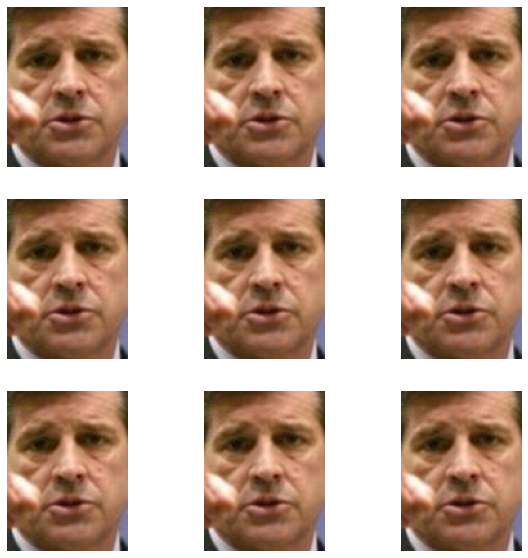

In [90]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')
## Not displaying correctly in Jupyter for unknown reason

## Rescale pixel values

In [91]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

## Building model


In [92]:
from keras.optimizers import SGD
from keras.layers import Dense
from keras.layers import Flatten
from keras.applications import ResNet50
import tensorflow as tf

# Change input shape to add image preprocessing
inputs = tf.keras.Input(shape=IMG_SHAPE)
y = preprocess_input(inputs)

# Create ResNet50 model
resnet = ResNet50(
    input_shape=[h, w, 3],
    weights="imagenet",
    include_top=False,
    classes=n_classes,
)
# Freeze layers for transfer learning
for layer in resnet.layers[: 10]:
    layer.trainable = False

# Add ResNet50 to the final model output
outputs = resnet(y)

# Change the ResNet50 output to be the number of class of the dataset
x = Flatten()(outputs)
x = Dense(n_classes, activation="softmax")(x)

# Assemble model
model = tf.keras.Model(inputs, x)

learning_rate = 0.001
nesterov = True
momentum = 0.9

opti = SGD(
    learning_rate=learning_rate,
    momentum=momentum,
    nesterov=nesterov,
)

# model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=opti, metrics=["accuracy"])
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer=opti, metrics=["accuracy"])
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 125, 94, 3)]      0         
                                                                 
 tf.__operators__.getitem_12  (None, 125, 94, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_12 (TFOpLamb  (None, 125, 94, 3)       0         
 da)                                                             
                                                                 
 resnet50 (Functional)       (None, 4, 3, 2048)        23587712  
                                                                 
 flatten_11 (Flatten)        (None, 24576)             0         
                                                                 
 dense_9 (Dense)             (None, 62)                1523

## Training

In [93]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_accuracy", patience=2)

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=50,
                    callbacks=[early_stop]
                    )

Epoch 1/50
31/31 [==============================] - 8s 127ms/step - loss: 3.9720 - accuracy: 0.2067 - val_loss: 4.5070 - val_accuracy: 0.1935
Epoch 2/50
31/31 [==============================] - 3s 90ms/step - loss: 0.2237 - accuracy: 0.9425 - val_loss: 3.5680 - val_accuracy: 0.3065
Epoch 3/50
31/31 [==============================] - 3s 90ms/step - loss: 0.0184 - accuracy: 0.9970 - val_loss: 2.5265 - val_accuracy: 0.4597
Epoch 4/50
31/31 [==============================] - 3s 91ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 2.0376 - val_accuracy: 0.5282
Epoch 5/50
31/31 [==============================] - 3s 91ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 1.7343 - val_accuracy: 0.5968
Epoch 6/50
31/31 [==============================] - 3s 93ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 1.5858 - val_accuracy: 0.6048
Epoch 7/50
31/31 [==============================] - 3s 95ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 1.5102 - val_accuracy: 0.6210
Epoch 8/50
3

## Save model

In [94]:
model.save_weights("../weights/resnet50_lfw.h5")
